# Geostatistics

## 3. Excursus: Time series

Time series analysis is a discipline of its own and is beyond the scope of this lecture. Nevertheless, a few basics will be covered that relate to geostatistics. We will cover:

* Describing a time series
* Time series decomposition

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from bokeh.plotting import output_notebook, show, figure
from bokeh.layouts import row, column, gridplot
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

## 3.1 Describing a time series

There are two major features of a time series, that we will look at. Both have their origin in the **ordered characteristic** of a time series. First we will look at the dynamics (the change of value over time) and second at the *autocorrelation* 

Load all data from the provided sample file and use the second column as `data` object

In [2]:
df = pd.read_csv('data/sample_data.txt', sep='\s+')
data = df.iloc[:,1]

### 3.1.1 Dynamics

By the dynamics of a timeseries we ask for the **change over time**.

For a series $x$ that has observations $x_{t}, x_{t+1}, x_{t+n}$ with $t$ the start point in time and $n$ the length of the timeseries the dynamics of $x$, denoted $d_x$ can be defined as:

$$d_x = \frac{\partial x}{\partial t}$$

For the discrete case of a sample we can simply take the differences:

$$d_{x_i} = x_i - x_{i - 1}$$

In [3]:
# time series plot
ts = figure(title='time series', width=800, height=200)
ts_line = ts.line(data.index, data.values)

# dynamics plot
diff = figure(title='Time series - dynamics', width=800, height=200, x_range=ts.x_range)
diff_line = diff.line(data.diff().index, data.diff().values, color='firebrick', alpha=0.7)

# create the hover tool
h1 = HoverTool(renderers=[ts_line], tooltips=[('','@y')], mode='vline')
h2 = HoverTool(renderers=[diff_line], tooltips=[('','@y')], mode='vline')
ts.add_tools(h1)
diff.add_tools(h2)

In [4]:
show(gridplot([[ts], [diff]]))

From this we can observe various things:


* The time series is not stable in time and changing. There seems to be a trend or a seasonality.
* The dynamics are much more stable: They change within a range, but there is no trend

* From what we can see here, there seems to be a large random component in the time series.

### 3.1.2 Autocorrelation

The concept of autocorrelation can be used to determine how much a time series is similar to itself.
To be more precise: **When** is it more self-similar and when not. For this to happen, a measure of **correlation** is chosen. 
The correlation between two samples measures their similarity.
The difference to the correlation calculated in the last lecture is that we calculate it over and over again. Each time, we shift the whole time series by one time step (called a **lag**). This way, we correlate the time series to **itself, but moments ago.**

Summarized:

* Find out **when** a time series showed similar values
* Learn about periodicity
* shift the time series by different time steps (*lags*)
* for discrete time series, the normed covariance is used
* visualize how the correlation relates to lag

The *normed covariance* $\rho$ is defined:

$$ \rho_{t_1, t_2} = \frac{Cov(X_{t_1}, X_{t_2})}{\sigma_{t_1} * \sigma_{t_2}} $$

for time series $X$ at two points in time $t_1, t_2$ and their standard deviations $\sigma$

For **stationary** time series, $\sigma_{t_1} == \sigma_{t_2}$ and the autocorrelation is simplified to the covariance

In [11]:
n  = 500
ac = []

for i in range(n):
    # shift by n places
    shifted = np.concatenate((data[i:], data[:i][::-1]))
    cf = np.cov(data.values, shifted) * (np.std(data.values), np.std(shifted))
    
    # use either (1,0) or (0,1) of correlation matrix
    ac.append(cf[0,1])

*You will find an exercise to implement this yourself.*

In [12]:
autocorr = figure(title='Autocorrelation', width=800, height=350)

renderer = autocorr.line(range(n), ac, color='firebrick', alpha=0.7)
hover = HoverTool(renderers=[renderer], tooltips=[('Corr: ','@y'), ('Lag', '@x')], mode='vline')

autocorr.add_tools(hover)

C:\Users\maelicke\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


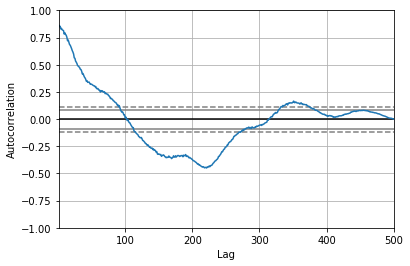

In [16]:
show(autocorr)

* The timeseries is highly *dis-similar* after 220 time steps
* After 330 - 350 time steps the correlation is on a local maximum again

*Here, a sub-section about trend analysis can be added.*

## 3.2 Timeseries decomposition

*Timeseries decomposition will only be covered very briefly, as this is beyond the scope of this lecture.*

By decomposing a time series, we extract **systematic** and **random** components from the signal and analyze them individually.

With **systematic**, we are referring to components that are recurring and structured. That means, we can describe these components mathematically and, in general terms, model them.

The **non-systematic** or **random** component is in terms of time series usually referred to as **noise**. This part can neither be predicted nor modeled and will make any prediction or modelling of the time series uncertain. This component usually origins from measurement errors, random processes in the system, scale effects or unknown system processes.

The four components of a time series signal that are usually decomposed are:

* **level**, which is the average value

* **trend**, which is a **long term** increase or decrease in level

* **seasonality**, which are **recurrent**, **short term** changes in value

* **noise**, which is a random variaton in value

In [8]:
# this is only for reference.
# I downloaded the CO2 dataset like shown in the Gaussian Process sklearn example:
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

if False: # Turn true if you want to re-download
    from sklearn.datasets import fetch_openml
    
    co2 = fetch_openml(data_id=41187)
    np.savetxt('./data/co2_con.txt', co2.target)

In [19]:
# seasonal decomposition
co2 = np.loadtxt('./data/co2_con.txt')

# it's weekly data from 29.03.1958 to 29.12.2001, but there are some missing values
# so I'll just adjust the start date
index = pd.date_range('19590514','20011229', freq='7d')

# decompose
res = seasonal_decompose(co2, model='additive', period=52)

w=350
h=250
# build the parts
#observations
co2_obs = figure(title='Global CO2 observation', width=w, height=h, x_axis_type="datetime", 
                 tooltips=[('CO2 con.', '@y ppm.')], tools=['xwheel_zoom,xbox_zoom,pan,reset,hover'])
co2_obs.line(index, co2, color='#6891C3', line_width=2)

# trend
co2_trend = figure(
    title='Trend component', width=w, height=h, x_axis_type="datetime", 
    tooltips=[('CO2 trend', '@y ppm.')], tools=['xwheel_zoom,xbox_zoom,pan,reset,hover'],
    x_range=co2_obs.x_range
)
co2_trend.line(index, res.trend, color='#AAC5E2', line_width=3)

# season
co2_season = figure(
    title='Seasonal component', width=w, height=h, x_axis_type="datetime", 
    tooltips=[('Seasonal comp.', '@y ppm.')], tools=['xwheel_zoom,xbox_zoom,pan,reset,hover'],
    x_range=co2_obs.x_range
)
co2_season.line(index, res.seasonal, color='#F4ADC6', line_width=3)

# noise
co2_noise = figure(
    title='Noise component', width=w, height=h, x_axis_type="datetime", 
    tooltips=[('Seasonal comp.', '@y ppm.')], tools=['xwheel_zoom,xbox_zoom,pan,reset,hover'],
    x_range=co2_obs.x_range
)
co2_noise.line(index, res.resid, color='#F692BC', line_width=3)

GlyphRenderer(id='3448', ...)

In [20]:
show(gridplot([[co2_obs, co2_trend], [co2_season, co2_noise]]))

* We can clearly see the perfect monotonically increasing CO2 concentration during the past decades.

* CO2 shows seasonality

* Since the 70', the residuals are quite stable

* We can compare the components to each other: since the 70' the random and seasonal compartments are of similar magnitude.

=> thus it would be challenging to model CO2 concentrations only from seasonal processes. We will need a **random process** to get good results.

If we want to gain insights on the processes driving the random component, we obviously need to decompose the time series.